Install PyOpenSky

In [1]:
!pip install pyopensky --upgrade
!mv secret.conf /root/.config/pyopensky/

  Using cached pyopensky-1.4-py3-none-any.whl (24 kB)
     |████████████████████████████████| 11.7 MB 19.9 MB/s eta 0:00:01
  Using cached paramiko-2.11.0-py2.py3-none-any.whl (212 kB)
  Using cached pyModeS-2.11-py3-none-any.whl (70 kB)
     |████████████████████████████████| 16.9 MB 73.3 MB/s eta 0:00:01
     |████████████████████████████████| 503 kB 81.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.1 MB 57.7 MB/s eta 0:00:01
  Using cached PyNaCl-1.5.0-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (856 kB)
  Using cached bcrypt-3.2.2-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (62 kB)
     |████████████████████████████████| 446 kB 65.7 MB/s eta 0:00:01
     |████████████████████████████████| 118 kB 101.1 MB/s eta 0:00:01
mv: failed to access '/root/.config/pyopensky/': Permission denied


holis

Perform Query

In [2]:
from pyopensky import OpenskyImpalaWrapper
import pandas as pd
import datetime

# Time of query
def to_epoch(timestamp):
  unix_epoch = datetime.datetime(1970, 1, 1)
  log_dt = datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
  seconds_from_epoch = (log_dt - unix_epoch).total_seconds()
  return seconds_from_epoch

from_time_str = '2022-04-22 13:00:00'
to_time_str = '2022-04-22 14:00:00'
from_time = to_epoch(from_time_str)
to_time = to_epoch(to_time_str)

# Area of query
min_lat, max_lat, min_lon, max_lon = (51.848578, 51.905650, -0.418809, -0.326079)

# Height of query
min_height, max_height = (0, 2000)

# OpenSky wrapper
opensky = OpenskyImpalaWrapper()
os_query = opensky.rawquery(
    f'SELECT * FROM state_vectors_data4 \
    WHERE lat >= {min_lat} AND lat <= {max_lat} \
    AND lon >= {min_lon} AND lon <= {max_lon} \
    AND hour >= {from_time} AND hour <= {to_time} \
    AND geoaltitude >= {min_height} AND geoaltitude <= {max_height};'
)

unique_callsigns = pd.unique(os_query['callsign'])
print(f'Query length: {len(unique_callsigns)}')

RuntimeError: Opensky Impala username and password are empty in /home/codespace/.config/pyopensky/secret.conf

Plot

In [ ]:
!pip install contextily
!pip install pyproj

<Figure size 432x288 with 0 Axes>

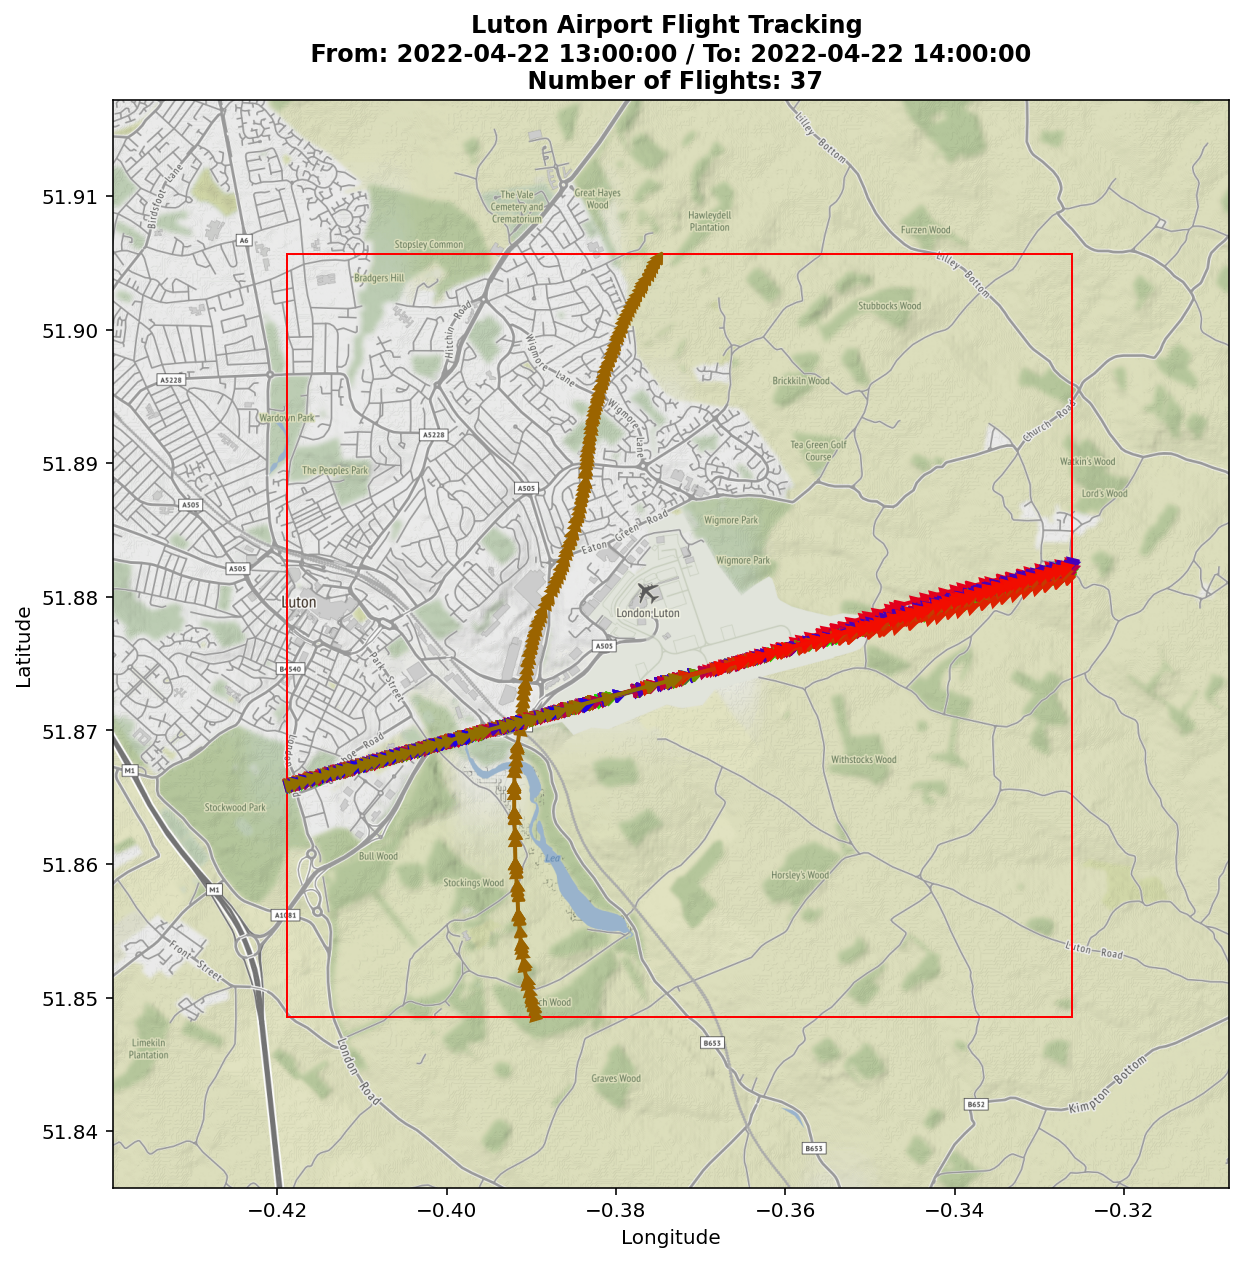

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import contextily as cx
from pyproj import Transformer
import plotly.graph_objects as go
%config InlineBackend.figure_format = 'retina'

unique_callsigns = pd.unique(os_query['callsign'])

plt.figure()
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Luton Airport Flight Tracking \n From: %s / To: %s \n Number of Flights: %s' % \
             (from_time_str, \
             to_time_str, \
             len(unique_callsigns)),\
             fontweight='bold')

number_of_colors = 100
cmap = plt.cm.get_cmap('brg', number_of_colors)

# Extract and plot map in Mercator coordinates
min_lat, max_lat, min_lon, max_lon = (51.848578, 51.905650, -0.418809, -0.326079)

trans_3857_4326 = Transformer.from_crs("epsg:3857", "epsg:4326")

ghent_img, ghent_ext = cx.bounds2img(min_lon, min_lat, max_lon, max_lat, ll=True, source=cx.providers.Stamen.Terrain)

minLat, minLon = trans_3857_4326.transform(ghent_ext[0], ghent_ext[2])
maxLat, maxLon = trans_3857_4326.transform(ghent_ext[1], ghent_ext[3])
ax.imshow(ghent_img, extent=(minLon, maxLon, minLat, maxLat))

# Transform box map coordinates and plot
rect = patches.Rectangle((min_lon, min_lat), max_lon-min_lon, max_lat-min_lat, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plot_data = []
for callsign in unique_callsigns:
  flight = os_query[os_query['callsign'] == callsign].reset_index(drop=True)
  color_index = random.randint(0,number_of_colors)
  ax.plot(flight['lon'],flight['lat'], '-', linewidth=2, color = cmap(color_index))

  for j in range(0, len(flight)):
    ax.plot(flight['lon'][j],flight['lat'][j], '-', marker=(3, 0, -flight['heading'][j]), markersize=7, color = cmap(color_index))

  plot_data.append(go.Scatter3d(x=flight['lon'], y=flight['lat'], z=flight['geoaltitude'], mode='markers', marker=dict(size=5,)))

ax.set_aspect('auto')

In [5]:
fig = go.Figure(data=plot_data)
fig.show()